In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad

In [3]:
import utils

In [4]:
"%—voxel1——-voxel2——-voxel3-—-voxel4——-voxel5——-voxel6"
seen_signal_x = np.loadtxt('./seenSignaX.txt', skiprows=1)
seen_signal = np.loadtxt('./seenSignal.txt', skiprows=1)

In [5]:
"%--dir-x---dir-y----dir-z-----|G|-----DELTA---delta-----TE---"
seen_scheme = np.loadtxt('./seenScheme.txt', skiprows=1)
unseen_scheme = np.loadtxt('./unseenScheme.txt', skiprows=1)

In [6]:
bvecs_seen = seen_scheme[:, :3]
bvecs_unseen = unseen_scheme[:, :3]

In [7]:
g_seen = seen_scheme[:, 3] * 1000 #mT/m
Delta_seen = seen_scheme[:, 4] * 1000 
delta_seen = seen_scheme[:, 5] * 1000
TE_seen = seen_scheme[:, 6] * 1000 # msec

g_unseen = unseen_scheme[:, 3] * 1000 #mT/m
Delta_unseen = unseen_scheme[:, 4] * 1000 
delta_unseen = unseen_scheme[:, 5] * 1000
TE_unseen = unseen_scheme[:, 6] * 1000 # msec

In [8]:
bvals_seen = utils.b_value(g_seen, delta_seen, Delta_seen)
bvals_unseen = utils.b_value(g_unseen, delta_unseen, Delta_unseen)

In [9]:
train_data = seen_signal[:, 0][::2]
train_bvals = bvals_seen[::2]
train_bvecs = bvecs_seen[::2]
train_delta = delta_seen[::2]
train_Delta = Delta_seen[::2]
train_te = TE_seen[::2]

test_data = seen_signal[:, 0][1::2]
test_bvals = bvals_seen[1::2]
test_bvecs = bvecs_seen[1::2]
test_delta = delta_seen[1::2]
test_Delta = Delta_seen[1::2]
test_te = TE_seen[1::2]

In [10]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)

In [11]:
train_s0 = train_data[train_gtab.b0s_mask]

In [12]:
p = np.polyfit(train_te[train_gtab.b0s_mask], np.log(train_data[train_gtab.b0s_mask]), 1)

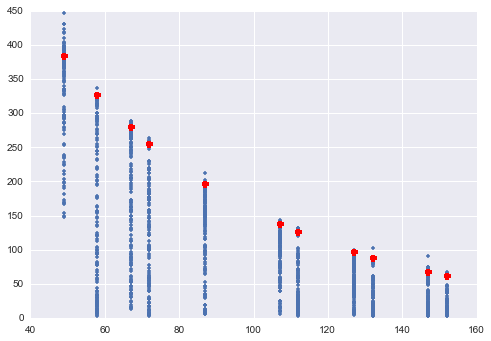

In [13]:
plt.plot(train_te, train_data, '.')
pred_lin = np.polyval(p, train_te)
plt.plot(train_te, np.exp(pred_lin), 'ro')

In [14]:
train_data_no_te = np.zeros_like(train_data)

In [15]:
for ii in range(train_data_no_te.shape[0]):
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    train_data_no_te[ii] = train_data[ii]/te_s0
    

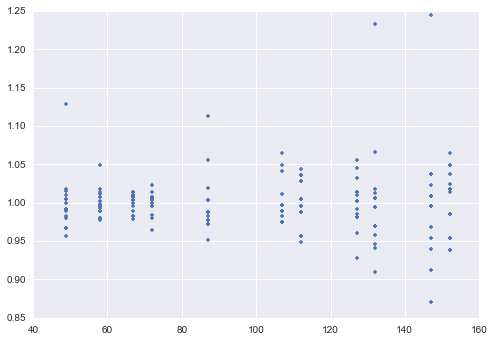

In [16]:
plt.plot(train_te[train_gtab.b0s_mask], train_data_no_te[train_gtab.b0s_mask], '.')

In [39]:
model = sfm.SparseFascicleModel(train_gtab, isotropic=sfm.ExponentialIsotropicModel)
#model = dti.TensorModel(train_gtab)

In [40]:
fit = model.fit(train_data_no_te)

In [41]:
train_data

array([ 402.8685,  366.    ,  388.    , ...,    6.6329,    4.8286,
         64.4491])

In [42]:
predict = fit.predict(train_gtab)

In [43]:
predict_with_te = np.zeros_like(predict)

In [44]:
for ii in range(predict_with_te.shape[0]):
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    predict_with_te[ii] = predict[ii] * te_s0
    

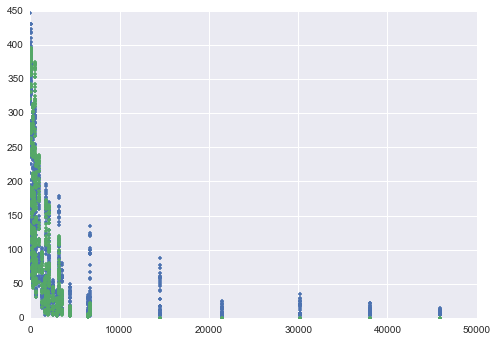

In [45]:
plt.plot(train_gtab.bvals, train_data, '.')
plt.plot(train_gtab.bvals, predict_with_te, '.')

In [46]:
def LSE(prediction, signal, sigma=8):
    return np.mean(((prediction - np.sqrt(signal**2 + sigma**2))**2)/(sigma**2))

In [47]:
LSE(predict_with_te, train_data)

5.3842634168964594

In [48]:
LSE(np.ones_like(train_data) * np.mean(train_data), train_data)

179.96553385160149

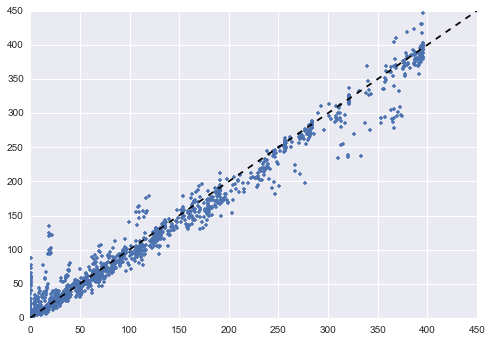

In [49]:
plt.plot(predict_with_te, train_data, '.')
plt.plot([0, 450], [0, 450], 'k--')